# Introduction

Addressing credit card fraud is a top priority for financial institutions, given the constant threat it poses to consumers and businesses. In Brazil alone, Serasa Experian reports that approximately 12.1 million people fell victim to financial fraud in the past year, resulting in a total loss of 1.8 billion reais over the last 12 months.

Effectively detecting fraud is a significant challenge, as legitimate and fraudulent transactions often bear similarities. The complexity is further heightened by the diversity of values and locations where fraud can occur, making pattern recognition challenging. This difficulty can lead to errors in both false positives, such as the preventive blocking of consumer cards, and false negatives, where fraudulent transactions go undetected.

To address this issue, it is crucial to continually enhance security systems, adopt advanced detection technologies, and invest in more robust authentication methods. Collaboration between financial institutions, regulators, and technology companies plays a pivotal role in developing more effective solutions to mitigate the risks associated with credit card fraud.

# Objectives

The objective of this project is to conduct an exploratory data analysis and build machine learning models capable of accurately detecting fraudulent transactions. To achieve this, advanced data analysis and machine learning techniques will be employed to identify patterns and anomalies in the data, along with data balancing techniques. Additionally, it will be crucial to assess the effectiveness of the constructed models, both in terms of accuracy in fraud detection and the minimization of false positives.

# Business Understanding

Fraudulent transactions involve the illicit acquisition of goods and services using stolen payment information. As credit card usage continues to rise, both online and offline, associated fraud activities also escalate. It is crucial for businesses to comprehend this threat, its various forms, and metrics to effectively monitor and combat such activities.

There're some Key Performance Indicators (KPIs) that is important to understand:
* **Acceptance**: The volume of transactions accepted after authorization and screening.
* **Challenges**: Transactions flagged as potentially fraudulent and subject to manual review.
* **Denials**: Payment requests rejected by the acquirer or identified as fraud before processing.
* **Chargebacks**: Transactions identified as fraud by the acquirer or contested by the customer.
* **False Positives**: Legitimate customer transactions incorrectly blocked as fraud.

Effective fraud management hinges on monitoring these KPIs diligently. Elevated false positive rates, for instance, can lead to lost sales and frustrated customers. Therefore, beyond safeguarding against fraud, companies must ensure their fraud detection solutions don't deter legitimate customers.

For this project, it is known that the company earns 10% of the value for a correctly approved payment and loses 100% in case of fraud:

* **Fraud Rate**: fraudulent transactions approved / total transactions approved
* **Approval Rate**: total transactions approved / transactions received



In [48]:

# Bibliotecas padrão
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow 
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.io as pio
import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly as ply

# Visualização de dados
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import missingno

# Testes estatísticos
from scipy.stats import chi2_contingency, mannwhitneyu
import scipy.stats as stats

# Modelos de machine learning e utilitários
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics import (roc_curve, auc, confusion_matrix, log_loss, roc_auc_score,
                             precision_score, recall_score, f1_score, make_scorer)
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce

# Classificadores e métodos de ensemble
from imblearn.ensemble import BalancedRandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

In [49]:
#%pip install openpyxl

file_path = "data/fraud_data.xlsx"

df = df = pd.read_excel(file_path)
df.head()

,score_1,score_2,score_3,score_4,score_5,score_6,pais,score_7,produto,categoria_produto,score_8,score_9,score_10,entrega_doc_1,entrega_doc_2,entrega_doc_3,data_compra,valor_compra,score_fraude_modelo,fraude
0,4,0.7685,94436.24,20.0,0.444828,1.0,BR,5,Máquininha Corta Barba Cabelo Peito Perna Pelo...,cat_8d714cd,0.883598,240.0,102.0,1,NaN,N,2020-03-27 11:51:16,5.64,66,0
1,4,0.7550,9258.50,1.0,0.000000,33.0,BR,0,Avental Descartavel Manga Longa - 50 Un. Tnt ...,cat_64b574b,0.376019,4008.0,0.0,1,Y,N,2020-04-15 19:58:08,124.71,72,0
2,4,0.7455,242549.09,3.0,0.000000,19.0,AR,23,Bicicleta Mountain Fire Bird Rodado 29 Alumini...,cat_e9110c5,0.516368,1779.0,77.0,1,NaN,N,2020-03-25 18:13:38,339.32,95,0
3,4,0.7631,18923.90,50.0,0.482385,18.0,BR,23,Caneta Delineador Carimbo Olho Gatinho Longo 2...,cat_d06e653,0.154036,1704.0,1147.0,1,NaN,Y,2020-04-16 16:03:10,3.54,2,0
4,2,0.7315,5728.68,15.0,0.000000,1.0,BR,2,Resident Evil Operation Raccoon City Ps3,cat_6c4cfdc,0.855798,1025.0,150.0,1,NaN,N,2020-04-02 10:24:45,3.53,76,0


In [50]:
print(df.shape)

(150000, 20)


# Dataset Dictionary

- **`score_1` a `score_10`**: 
  - Description: Credit bureau scores.
  - Purpose: Used to assess the buyer's reliability.
  
- **`Pais` (`Country`)**: 
  - Description: Country where the purchase was made.

- **`Produto` (`Product`)**: 
  - Description: Specific item acquired on the e-commerce platform.

- **`Categoria_produto` (`Produc Category`)**: 
  - Description: Classification of the product within the e-commerce platform.

- **`Entrega_doc_1` a `entrega_doc_3` (`Document Delivery Indicators`)**: 
  - Description: Indicators of document delivery at the account creation stage.
  - Values: 
    - **0** or **N**: Did not deliver.
    - **1** or **Y**: Delivered.
    - Blank: Considered as not delivered.

- **`Score_fraude_modelo` (`Fraud Model Score`)**: 
  - Description: Probability, provided by the current model, of a purchase being fraudulent.
  - Values: Ranges from 0 to 100. The closer to 100, the higher the model's confidence that the transaction is fraudulent.

- **`Fraude` (`Fraud`)**: 
  - Description: Verification of the authenticity of the purchase.
  - Valores: 
    - **0**: Legitimate transaction.
    - **1**: Fraudulent transaction.
  - Note: This information is confirmed a few days after the transaction to ensure accuracy.


# Data Exploratory Analysis

In [51]:
# Visualizar o tamanho do dataframe
print(f"Number of samples: {df.shape[0]}")
print(f"Number of variables: {df.shape[1]}")

Number of samples: 150000
Number of variables: 20


In [52]:
df.columns

Index(['score_1', 'score_2', 'score_3', 'score_4', 'score_5', 'score_6',
       'pais', 'score_7', 'produto', 'categoria_produto', 'score_8', 'score_9',
       'score_10', 'entrega_doc_1', 'entrega_doc_2', 'entrega_doc_3',
       'data_compra', 'valor_compra', 'score_fraude_modelo', 'fraude'],
      dtype='object')

In [53]:
df.dtypes

score_1                         int64
score_2                       float64
score_3                       float64
score_4                       float64
score_5                       float64
score_6                       float64
pais                           object
score_7                         int64
produto                        object
categoria_produto              object
score_8                       float64
score_9                       float64
score_10                      float64
entrega_doc_1                   int64
entrega_doc_2                  object
entrega_doc_3                  object
data_compra            datetime64[ns]
valor_compra                  float64
score_fraude_modelo             int64
fraude                          int64
dtype: object

## Null values

In [54]:
## percentage of null values
df.isnull().mean() * 100

score_1                 0.000000
score_2                 8.656000
score_3                 8.656000
score_4                 0.243333
score_5                 0.000000
score_6                 0.007333
pais                    0.129333
score_7                 0.000000
produto                 0.000000
categoria_produto       0.000000
score_8                 0.000000
score_9                 0.007333
score_10                0.243333
entrega_doc_1           0.000000
entrega_doc_2          72.571333
entrega_doc_3           0.000000
data_compra             0.000000
valor_compra            0.000000
score_fraude_modelo     0.000000
fraude                  0.000000
dtype: float64

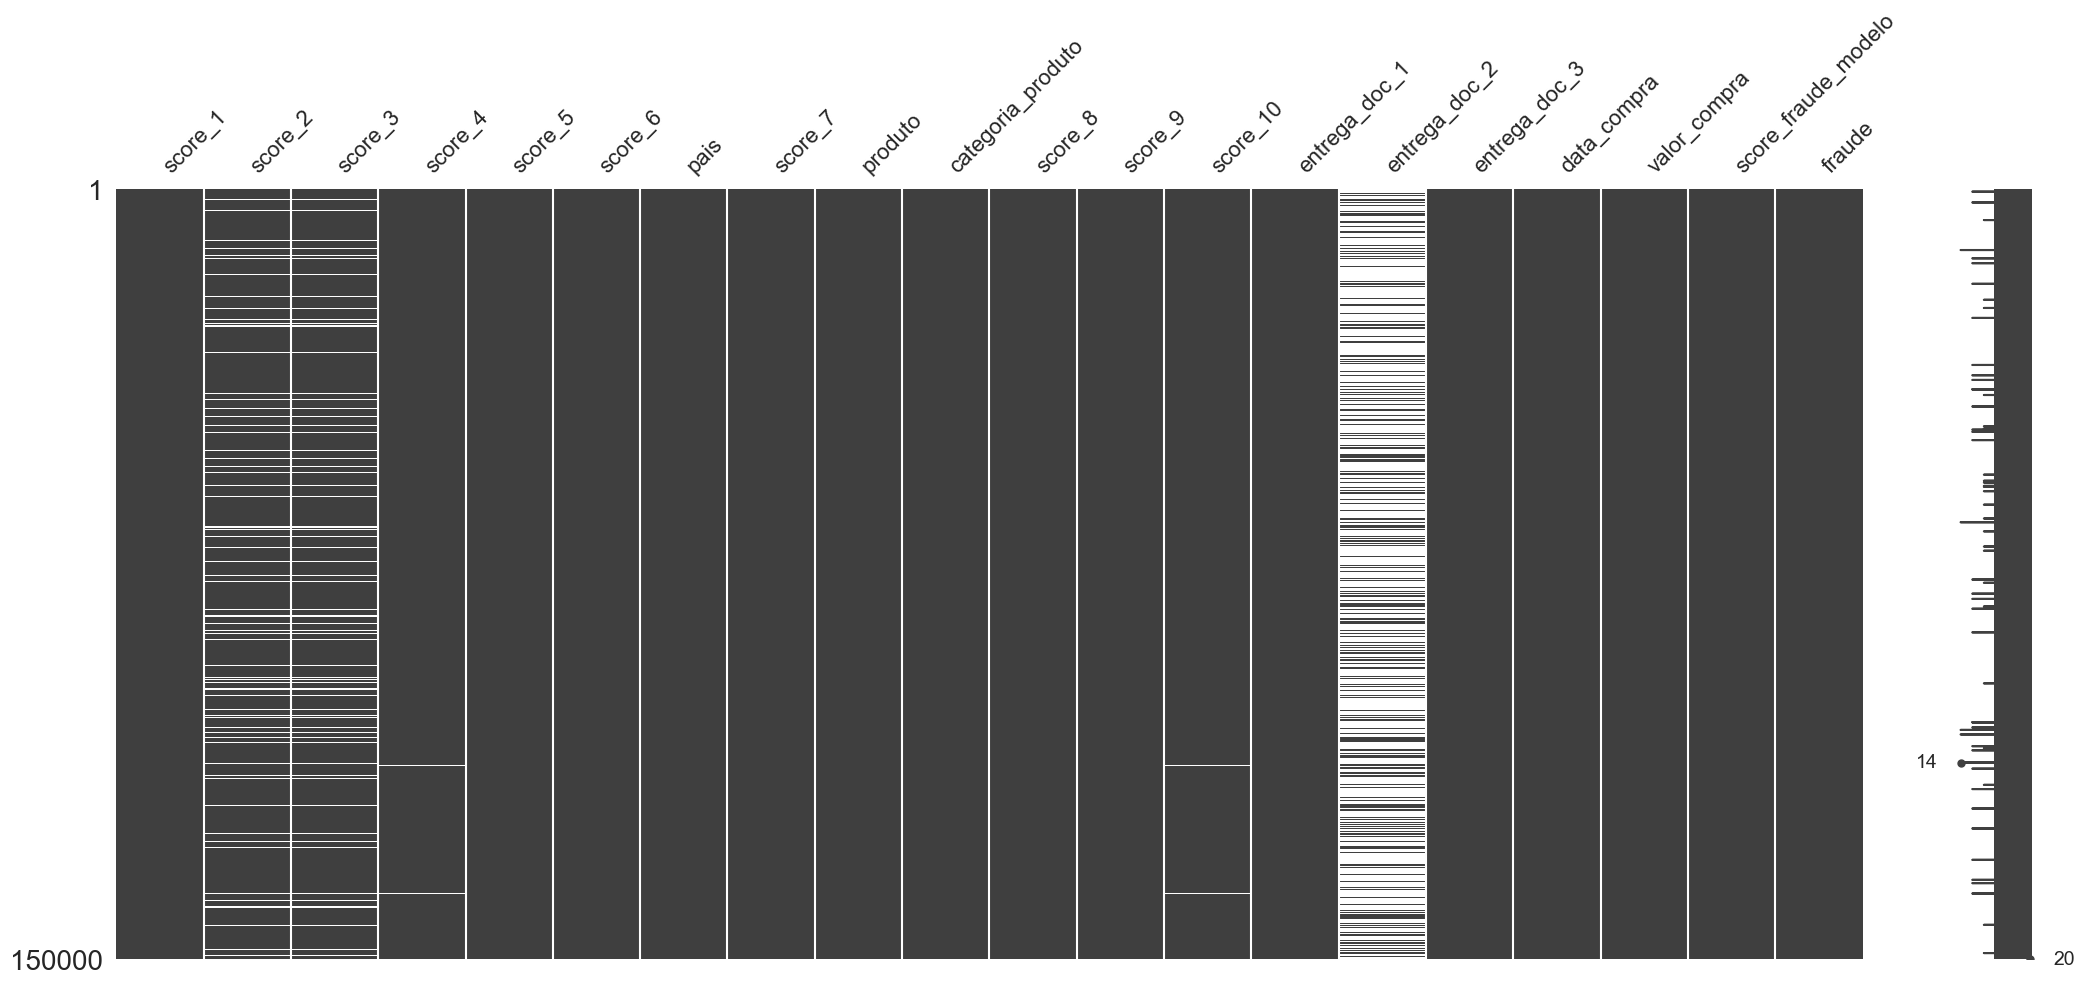

In [55]:
missingno.matrix(df);

The column `entrega_doc_2`, as previously observed, has 72% of null entries. In this context, null values may indicate individuals who did not deliver the required documents. However, this lack of document submission can potentially aid in detecting fraudsters. In such instances, it is advisable to create a new boolean feature (column) indicating whether the document was delivered or not (1: delivered, 0: null entry).

## Univariate Data Analysis

As the variable score_1 ranges from 1 to 4, I will consider it categorical. Below is a bar chart representing this distribution.

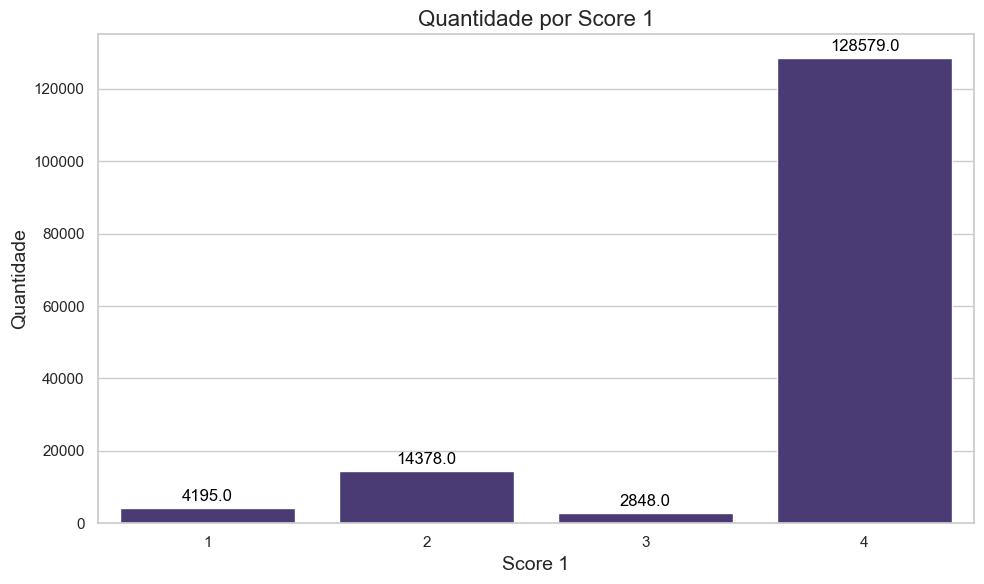

In [56]:
import plotly.express as px
import plotly.graph_objects as go

#%pip install nbformat

# Utilizando a paleta de cores 'viridis'
sns.set_palette("viridis")

# Criando o gráfico
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='score_1', data=df)
sns.set_style("darkgrid", {"grid.color": ".5", "grid.linestyle": ":"})

# Adicionando título e rótulos aos eixos
ax.set_xlabel("Score 1", fontsize=14)
ax.set_ylabel("Quantidade", fontsize=14)
ax.set_title("Quantidade por Score 1", fontsize=16)

# Adicionando anotações sobre as barras
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

# Ajustando o layout
plt.tight_layout()

# Exibindo o gráfico
plt.show()


It is possible to observe that the majority of users belong to category 4.

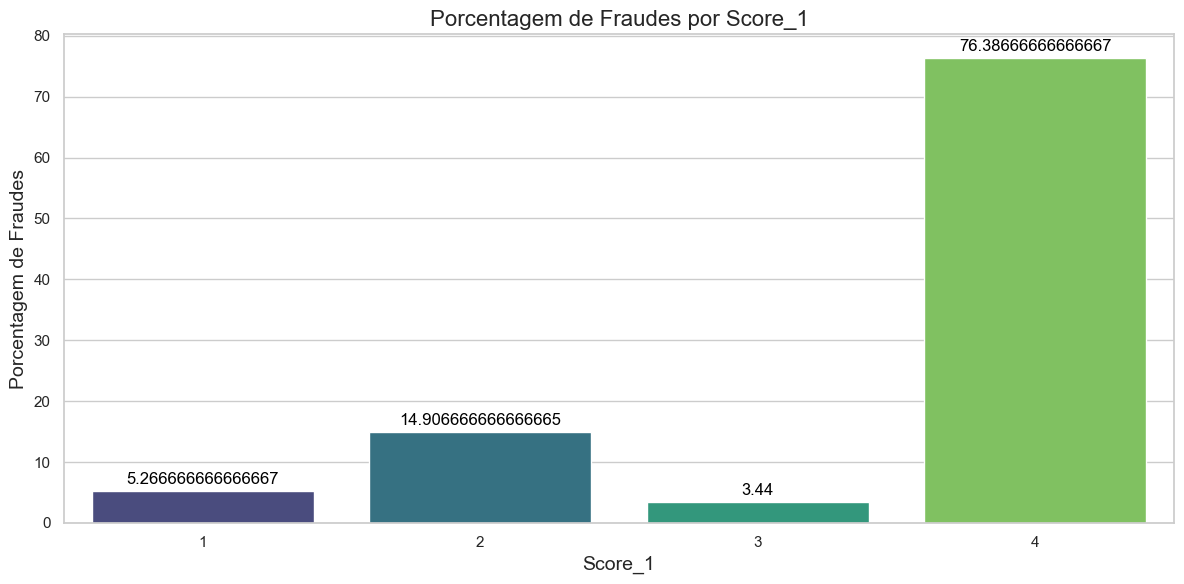

In [57]:
# Filtrar dados apenas para fraudes
fraud_df = df[df['fraude'] == 1]

# Calcular a porcentagem de fraude para cada valor único em 'score_1'
percentage_fraud = (fraud_df['score_1'].value_counts(normalize=True) * 100).reset_index()
percentage_fraud.columns = ['Score_1', 'Porcentagem de Fraudes']

# Criar o gráfico de barras usando Seaborn
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")
ax = sns.barplot(x='Score_1', y='Porcentagem de Fraudes', data=percentage_fraud, palette='viridis')

# Adicionando anotações sobre as barras
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')


# Adicionar título e rótulos aos eixos
plt.title("Porcentagem de Fraudes por Score_1", fontsize=16)
plt.xlabel("Score_1", fontsize=14)
plt.ylabel("Porcentagem de Fraudes", fontsize=14)

# Ajustar o layout
plt.tight_layout()

# Exibir o gráfico
plt.show()

Similarly, the majority of frauds are allocated in categories 4 and 2. Now, let's examine the cardinality of the `country` variable.

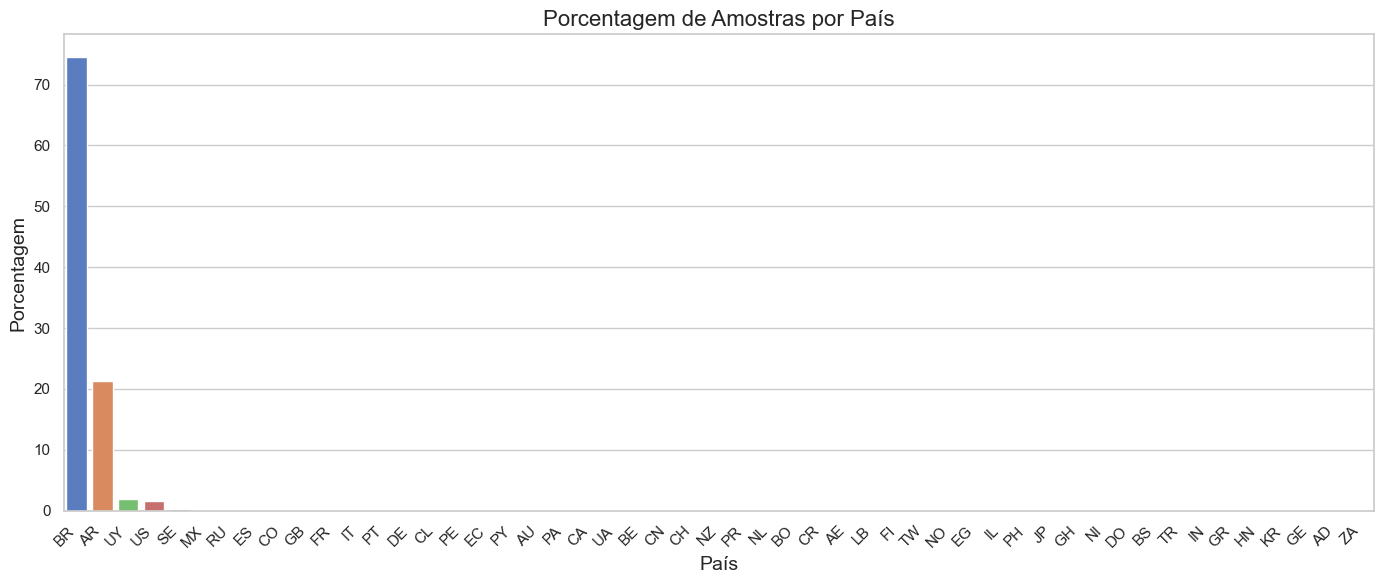

In [58]:
# Calcular a porcentagem de amostras para cada país (pais)
percentage_by_country = (df['pais'].value_counts(normalize=True) * 100).reset_index()
percentage_by_country.columns = ['Pais', 'Porcentagem']

# Criar o gráfico de barras usando Seaborn
plt.figure(figsize=(14, 6))
sns.set(style="whitegrid")
ax = sns.barplot(x='Pais', y='Porcentagem', data=percentage_by_country, palette='muted')

# Adicionar título e rótulos aos eixos
plt.title("Porcentagem de Amostras por País", fontsize=16)
plt.xlabel("País", fontsize=14)
plt.ylabel("Porcentagem", fontsize=14)

# Rotacionar os rótulos do eixo x para melhor legibilidade
plt.xticks(rotation=45, ha="right")

# Ajustar o layout
plt.tight_layout()

# Exibir o gráfico
plt.show()


In [59]:
len(df['pais'].unique())

52

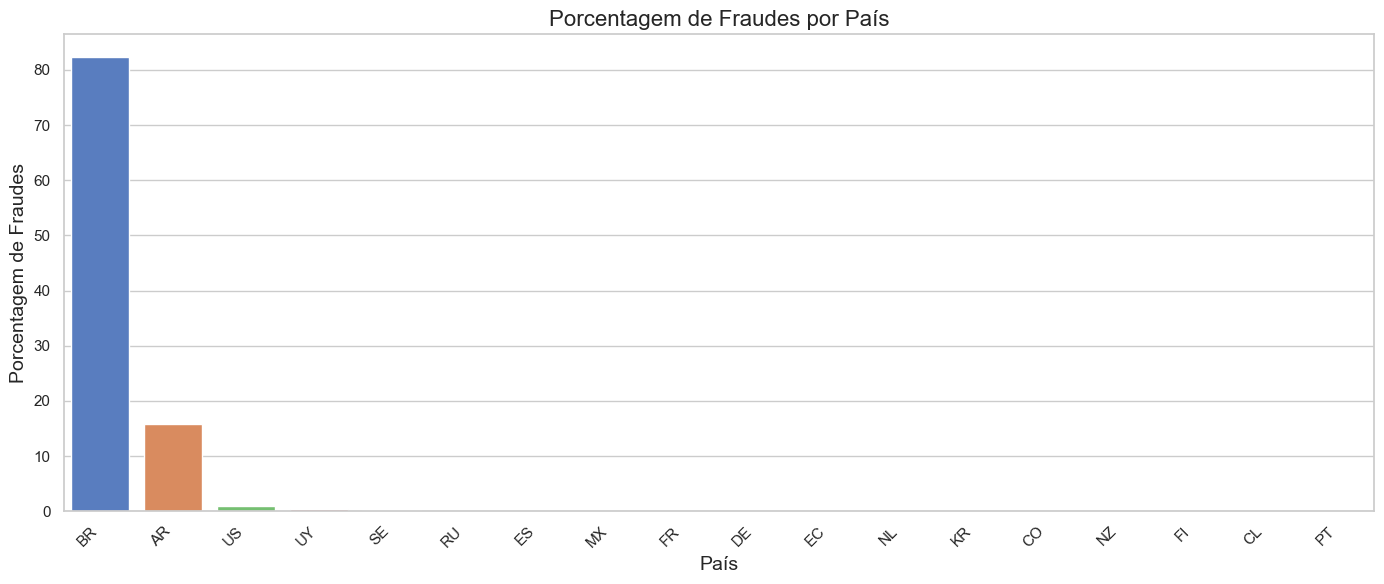

In [60]:
# Filtrar o DataFrame para incluir apenas amostras onde fraude = 1
fraud_df = df[df['fraude'] == 1]

# Calcular a porcentagem de fraudes para cada país (pais)
percentage_fraud_by_country = (fraud_df['pais'].value_counts(normalize=True) * 100).reset_index()
percentage_fraud_by_country.columns = ['Pais', 'Porcentagem de Fraudes']

# Criar o gráfico de barras usando Seaborn
plt.figure(figsize=(14, 6))
sns.set(style="whitegrid")
ax = sns.barplot(x='Pais', y='Porcentagem de Fraudes', data=percentage_fraud_by_country, palette='muted')

# Adicionar título e rótulos aos eixos
plt.title("Porcentagem de Fraudes por País", fontsize=16)
plt.xlabel("País", fontsize=14)
plt.ylabel("Porcentagem de Fraudes", fontsize=14)

# Rotacionar os rótulos do eixo x para melhor legibilidade
plt.xticks(rotation=45, ha="right")

# Ajustar o layout
plt.tight_layout()

# Exibir o gráfico
plt.show()

There are 52 countries in the dataset, where Brazil and Argentina together represent more than 90% of the dataset.

Now, let's consider the `product` variable

In [61]:
## count amount of products (produto)
print(f'amount of products: {len(df["produto"].unique())}')
df['produto'].value_counts()

amount of products: 127804


produto
Fone De Ouvido Sem Fio Xiaomi Airdots Preto                     83
Xiaomi Redmi Note 8 Dual Sim 64 Gb Azul-netuno 4 Gb Ram         51
Clean Sept - Álcool Em Gel 70% 500 Ml                           49
Tapete Ilustrativo Pista Carrinho Hot Wheels 0,60x1,20m         47
Máscara Descartável Tripla Com Elástico Proteção Anvisa 50un    47
                                                                ..
Bateria Zetta, Nova, Com Nota Fiscal, 12 Mês De Garantia         1
Dispenser Jabón Liquido / Alcohol En Gel X Unidad                1
Moletom Gola Redonda Shawn Mendes Top 98 Unissex Promoção        1
Placa Interface Adesivo Lavadora Brastemp Bwl11 Emicol Biv.      1
A Magia Divina Das Velas. O Livro Das Sete Chamas Sagradas       1
Name: count, Length: 127804, dtype: int64

A high cardinality can be very detrimental to the model because there is a significant chance that these specific features do not discriminate patterns and, therefore, do not add any value to the model. Additionally, high cardinality can make the data very sparse, affecting the model's performance

Cardinality refers to the number of unique values in a categorical feature. High cardinality can pose challenges in modeling, as it may lead to overfitting, increased computational complexity, and difficulty in identifying meaningful patterns in the data. Reducing cardinality through techniques like grouping or feature engineering may be necessary to improve model performance.

To better understand and develop intuition, I will create a word cloud for the term `product`.

In [62]:
## count the missing values in the `produto` column
df['produto'].isnull().sum()

0

In [63]:
## concatenate every product name in a single string
products = ' '.join(df['produto'].astype(str).tolist())

## count the number of words in the string
print(len(products.split()))

1315166


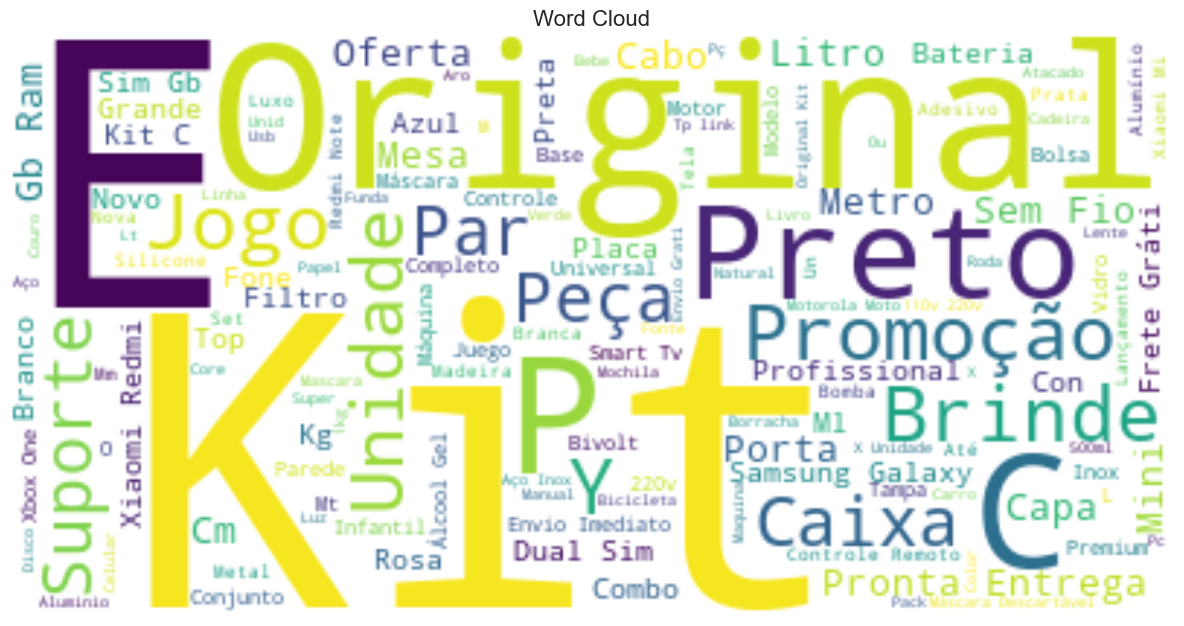

In [98]:
import plotly.graph_objects as go
from wordcloud import WordCloud, STOPWORDS

# Sua lista de stopwords
stopwords = set(STOPWORDS)
stopwords.update(["da", "meu", "em", "você", "de", "ao", "os", "br", "para", "por", "com", "na", "das", "dos", "nos", "nos"])

# Especifique um arquivo de fonte TrueType instalado no seu sistema
# font_path = "utils/ARIAL.TTF"  # Substitua pelo caminho para um arquivo de fonte TrueType no seu sistema

# Crie uma nuvem de palavras
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(products)

# Ajuste o tamanho da imagem da nuvem de palavras
plt.figure(figsize=(12, 10))

# Transforme a nuvem de palavras em uma imagem
wordcloud_image = wordcloud.to_image()

# Crie um gráfico mais personalizado usando Seaborn
sns.set(style="whitegrid")
plt.imshow(wordcloud_image, interpolation='bilinear')
plt.axis("off")

# Adicione título ao gráfico
plt.title("Word Cloud", fontsize=16)

# Ajuste o layout
plt.tight_layout()

# Exiba o gráfico
plt.show()


Let's now consider the `categoria_produto` variable.

In [65]:
df['categoria_produto'].value_counts(), print(f'amount of categories: {len(df["categoria_produto"].unique())}')

amount of categories: 8324


(categoria_produto
 cat_43b9c10    2331
 cat_d69bed9    1799
 cat_604df77    1784
 cat_6c4cfdc    1449
 cat_4249bd8    1191
                ... 
 cat_0d1c81b       1
 cat_4fc8b8b       1
 cat_9ba475f       1
 cat_75e1eaf       1
 cat_45b507c       1
 Name: count, Length: 8324, dtype: int64,
 None)

In [66]:
## count amount of item for each category
numbers_of_items_for_category = df['categoria_produto'].value_counts().reset_index()
## rename count column to number_of_items
numbers_of_items_for_category.rename(columns={'count': 'amount_of_itens'}, inplace=True)

print(len(numbers_of_items_for_category))
numbers_of_items_for_category

8324


,categoria_produto,amount_of_itens
0,cat_43b9c10,2331
1,cat_d69bed9,1799
2,cat_604df77,1784
3,cat_6c4cfdc,1449
4,cat_4249bd8,1191
...,...,...
8319,cat_0d1c81b,1
8320,cat_4fc8b8b,1
8321,cat_9ba475f,1
8322,cat_75e1eaf,1


In [67]:
## count the percentage of fraud for each category
percentage_of_fraud_for_category = (fraud_df['categoria_produto'].value_counts(normalize=True) * 100).reset_index()

## rename the proportion columns to percentage of fraud
percentage_of_fraud_for_category.rename(columns={'proportion': 'percentage_of_fraud'}, inplace=True)

print(len(percentage_of_fraud_for_category))
percentage_of_fraud_for_category

1959


,categoria_produto,percentage_of_fraud
0,cat_43b9c10,5.066667
1,cat_d9753d4,1.533333
2,cat_4249bd8,1.306667
3,cat_8ef7164,1.080000
4,cat_6c4cfdc,0.986667
...,...,...
1954,cat_423f96f,0.013333
1955,cat_87544ff,0.013333
1956,cat_5d01116,0.013333
1957,cat_768a0d8,0.013333


In [68]:
## count the amount of fraud for each category
amount_of_fraud_for_category = fraud_df['categoria_produto'].value_counts().reset_index()
## add the cum sum of fraud for each category
# amount_of_fraud_for_category['cumsum_of_frauds'] = amount_of_fraud_for_category['count'].cumsum()

## rename the count column to amount_of_frauds
amount_of_fraud_for_category.rename(columns={'count': 'amount_of_frauds'}, inplace=True)

print(len(amount_of_fraud_for_category))
amount_of_fraud_for_category

1959


,categoria_produto,amount_of_frauds
0,cat_43b9c10,380
1,cat_d9753d4,115
2,cat_4249bd8,98
3,cat_8ef7164,81
4,cat_6c4cfdc,74
...,...,...
1954,cat_423f96f,1
1955,cat_87544ff,1
1956,cat_5d01116,1
1957,cat_768a0d8,1


In [69]:
## merge amount of fraud, percentage of fraud and number of itens for each category
## the merge will be done using the column 'categoria_produto' column, that they all have in common
df_product_category = pd.merge(numbers_of_items_for_category, percentage_of_fraud_for_category, on='categoria_produto')
df_product_category = pd.merge(df_product_category, amount_of_fraud_for_category, on=['categoria_produto'], how = 'left')

## add the cumsum of percent of fraud
df_product_category['cumsum_%_frauds'] = df_product_category['percentage_of_fraud'].cumsum()
df_product_category

,categoria_produto,amount_of_itens,percentage_of_fraud,amount_of_frauds,cumsum_%_frauds
0,cat_43b9c10,2331,5.066667,380,5.066667
1,cat_d69bed9,1799,0.720000,54,5.786667
2,cat_604df77,1784,0.946667,71,6.733333
3,cat_6c4cfdc,1449,0.986667,74,7.720000
4,cat_4249bd8,1191,1.306667,98,9.026667
...,...,...,...,...,...
1954,cat_f20ecd7,1,0.013333,1,99.946667
1955,cat_97616e6,1,0.013333,1,99.960000
1956,cat_bdb5a4c,1,0.013333,1,99.973333
1957,cat_141c8e9,1,0.013333,1,99.986667


In [70]:
## filter the cumsum 80% of frauds
df_product_category[df_product_category['cumsum_%_frauds'] <= 80]

,categoria_produto,amount_of_itens,percentage_of_fraud,amount_of_frauds,cumsum_%_frauds
0,cat_43b9c10,2331,5.066667,380,5.066667
1,cat_d69bed9,1799,0.720000,54,5.786667
2,cat_604df77,1784,0.946667,71,6.733333
3,cat_6c4cfdc,1449,0.986667,74,7.720000
4,cat_4249bd8,1191,1.306667,98,9.026667
...,...,...,...,...,...
832,cat_420ad98,30,0.053333,4,79.880000
833,cat_ba55765,30,0.040000,3,79.920000
834,cat_a0d02a8,30,0.026667,2,79.946667
835,cat_3853682,29,0.013333,1,79.960000


In [71]:
## plot a line chart of the cumsum of frauds
fig = px.line(
    df_product_category,
    x='categoria_produto',
    y='cumsum_%_frauds',
    labels={'index': 'Categoria do Produto', 'categoria_produto': 'Porcentagem Acumulada de Fraudes'},
)

fig.update_layout(
    xaxis_title="Categoria do Produto",
    yaxis_title="Porcentagem Acumulada de Fraudes",
    title="Porcentagem Acumulada de Fraudes x Categoria do Produto"
)

fig.show()

It's worth noting that there are more than 8,000 categories in total, but only about 2,000 of them have instances of fraud. Among these 2,000 categories, 837 of them account for approximately 80% of all registered frauds.

 important consideration is that we could group these subcategories into larger categories, thereby reducing cardinality (e.g., clothing, electronics, etc.). This information is not available in the dataset, but it could be extracted from other databases. In case it's not available in other databases, a widget could be created for sellers to classify the product in a more macro way. If that is not possible either, we could develop an NLP and classification model capable of understanding possible macro classes of the product. Alternatively, an unsupervised clustering model with information that discriminates the product (price, customer profile, etc.) could be created.

Let's consider the variable `entrega_doc_1`.

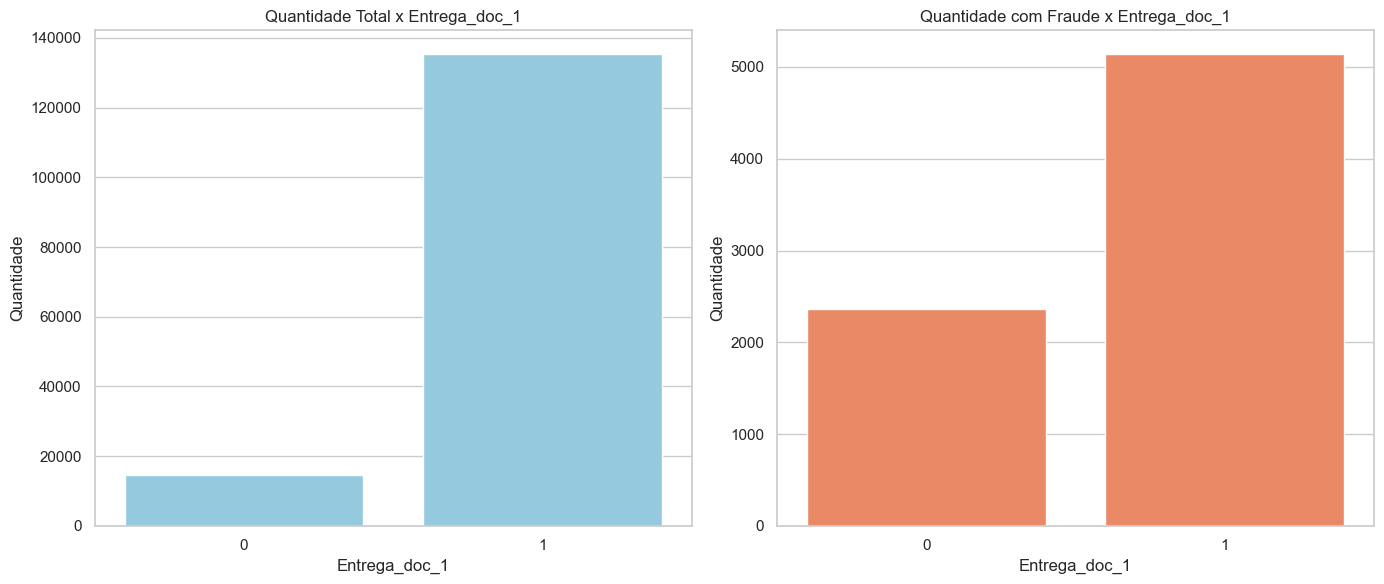

In [72]:
import plotly.graph_objects as go

# Total quantity for entrega_doc_1
total_quantity = df['entrega_doc_1'].value_counts().reset_index()

# Quantity for entrega_doc_1 with fraud
fraud_quantity = df[df['fraude'] == 1].groupby(['entrega_doc_1']).size().reset_index(name='Quantidade')

# Configuração do estilo do seaborn
sns.set(style="whitegrid")

# Criação do gráfico de barras utilizando o seaborn
plt.figure(figsize=(14, 6))

# Gráfico da Quantidade Total x Entrega_doc_1
plt.subplot(1, 2, 1)
sns.barplot(x='entrega_doc_1', y='count', data=total_quantity, color='skyblue')
plt.xlabel("Entrega_doc_1")
plt.ylabel("Quantidade")
plt.title("Quantidade Total x Entrega_doc_1")

# Gráfico da Quantidade com Fraude x Entrega_doc_1
plt.subplot(1, 2, 2)
sns.barplot(x='entrega_doc_1', y='Quantidade', data=fraud_quantity, color='coral')
plt.xlabel("Entrega_doc_1")
plt.ylabel("Quantidade")
plt.title("Quantidade com Fraude x Entrega_doc_1")

# Ajustes finais de layout
plt.tight_layout()

# Exibição do gráfico
plt.show()

In [73]:
# Criar uma tabela de contingência
contingency_table = pd.crosstab(df["entrega_doc_1"], df["fraude"])

# Realizar o teste do qui-quadrado
chi2, p, _, _ = chi2_contingency(contingency_table)

print("Chi-squared value:", chi2)
print("P-value:", p)

if p < 0.05:
    print("We reject the null hypothesis. There is a significant relationship between 'delivery_doc_1' and 'fraud'.")
else:
    print("We do not reject the null hypothesis. 'Delivery_doc_1' and 'fraud' appear to be independent.")

Chi-squared value: 4217.317158934374
P-value: 0.0
We reject the null hypothesis. There is a significant relationship between 'delivery_doc_1' and 'fraud'.


There is an imbalance, where the majority of users have submitted document 1.

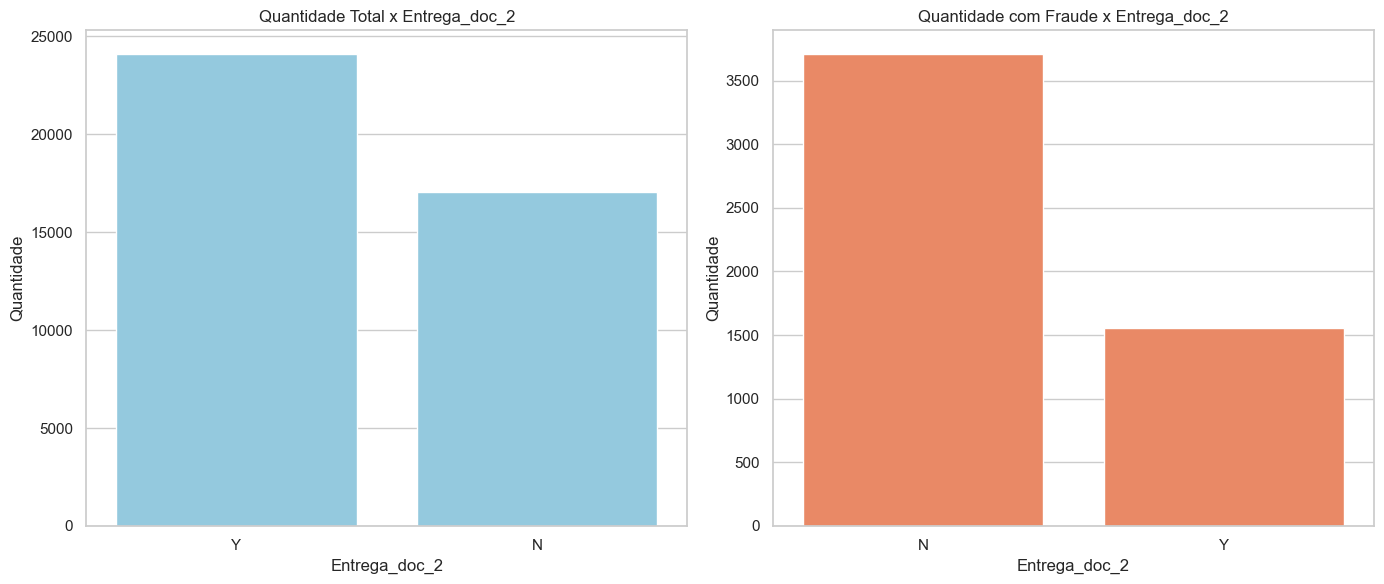

In [74]:
import plotly.graph_objects as go

# Total quantity for entrega_doc_2
total_quantity = df['entrega_doc_2'].value_counts().reset_index()

# Quantity for entrega_doc_2 with fraud
fraud_quantity = df[df['fraude'] == 1].groupby(['entrega_doc_2']).size().reset_index(name='Quantidade')

# Configuração do estilo do seaborn
sns.set(style="whitegrid")

# Criação do gráfico de barras utilizando o seaborn
plt.figure(figsize=(14, 6))

# Gráfico da Quantidade Total x Entrega_doc_2
plt.subplot(1, 2, 1)
sns.barplot(x='entrega_doc_2', y='count', data=total_quantity, color='skyblue')
plt.xlabel("Entrega_doc_2")
plt.ylabel("Quantidade")
plt.title("Quantidade Total x Entrega_doc_2")

# Gráfico da Quantidade com Fraude x Entrega_doc_2
plt.subplot(1, 2, 2)
sns.barplot(x='entrega_doc_2', y='Quantidade', data=fraud_quantity, color='coral')
plt.xlabel("Entrega_doc_2")
plt.ylabel("Quantidade")
plt.title("Quantidade com Fraude x Entrega_doc_2")

# Ajustes finais de layout
plt.tight_layout()

# Exibição do gráfico
plt.show()


In [75]:
# Criar uma tabela de contingência
contingency_table = pd.crosstab(df["entrega_doc_1"], df["fraude"])

# Realizar o teste do qui-quadrado
chi2, p, _, _ = chi2_contingency(contingency_table)

print("Chi-squared value:", chi2)
print("P-value:", p)

if p < 0.05:
    print("We reject the null hypothesis. There is a significant relationship between 'delivery_doc_2' and 'fraud'.")
else:
    print("We do not reject the null hypothesis. 'Delivery_doc_2' and 'fraud' appear to be independent.")

Chi-squared value: 4217.317158934374
P-value: 0.0
We reject the null hypothesis. There is a significant relationship between 'delivery_doc_2' and 'fraud'.


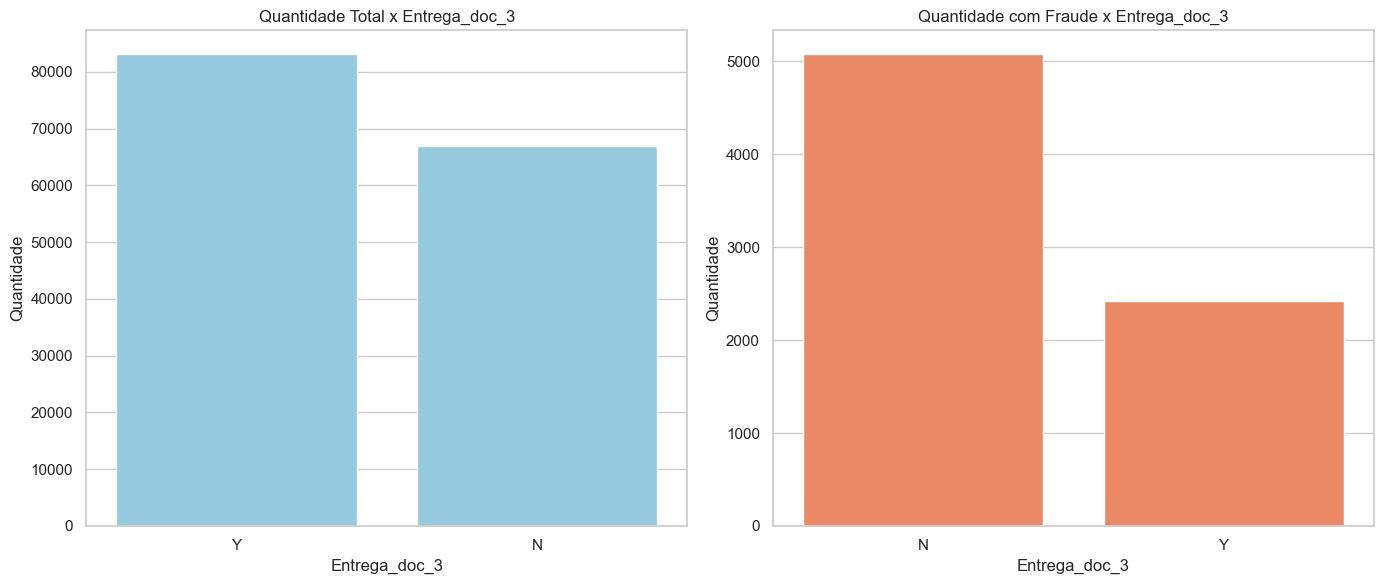

In [76]:
## do the same thing but for the column 'entrega_doc_3'

import plotly.graph_objects as go

# Total quantity for entrega_doc_3
total_quantity = df['entrega_doc_3'].value_counts().reset_index()

# Quantity for entrega_doc_3 with fraud
fraud_quantity = df[df['fraude'] == 1].groupby(['entrega_doc_3']).size().reset_index(name='Quantidade')

# Configuração do estilo do seaborn
sns.set(style="whitegrid")

# Criação do gráfico de barras utilizando o seaborn
plt.figure(figsize=(14, 6))

# Gráfico da Quantidade Total x Entrega_doc_3
plt.subplot(1, 2, 1)
sns.barplot(x='entrega_doc_3', y='count', data=total_quantity, color='skyblue')
plt.xlabel("Entrega_doc_3")
plt.ylabel("Quantidade")
plt.title("Quantidade Total x Entrega_doc_3")

# Gráfico da Quantidade com Fraude x Entrega_doc_3
plt.subplot(1, 2, 2)
sns.barplot(x='entrega_doc_3', y='Quantidade', data=fraud_quantity, color='coral')
plt.xlabel("Entrega_doc_3")
plt.ylabel("Quantidade")
plt.title("Quantidade com Fraude x Entrega_doc_3")

# Ajustes finais de layout
plt.tight_layout()

# Exibição do gráfico
plt.show()

In [77]:
# Criar uma tabela de contingência
contingency_table = pd.crosstab(df["entrega_doc_1"], df["fraude"])

# Realizar o teste do qui-quadrado
chi2, p, _, _ = chi2_contingency(contingency_table)

print("Chi-squared value:", chi2)
print("P-value:", p)

if p < 0.05:
    print("We reject the null hypothesis. There is a significant relationship between 'delivery_doc_3' and 'fraud'.")
else:
    print("We do not reject the null hypothesis. 'Delivery_doc_3' and 'fraud' appear to be independent.")

Chi-squared value: 4217.317158934374
P-value: 0.0
We reject the null hypothesis. There is a significant relationship between 'delivery_doc_3' and 'fraud'.


## Numerical Variables

In [78]:
df.describe()

,score_1,score_2,score_3,score_4,score_5,score_6,score_7,score_8,score_9,score_10,entrega_doc_1,data_compra,valor_compra,score_fraude_modelo,fraude
count,150000.000000,137016.000000,1.370160e+05,149635.000000,150000.000000,149989.000000,150000.000000,150000.000000,149989.000000,149635.000000,150000.000000,150000,150000.000000,150000.000000,150000.000000
mean,3.705407,0.728115,2.604451e+05,21.677669,0.220641,51.169352,14.193513,0.497532,2305.409403,299.969579,0.902353,2020-03-30 23:41:40.546252800,43.523134,48.066240,0.050000
min,1.000000,0.000000,1.600000e-01,0.000000,0.000000,-5.000000,0.000000,0.000004,0.000000,0.000000,0.000000,2020-03-08 00:02:15,0.020000,0.000000,0.000000
25%,4.000000,0.678400,9.679915e+03,2.000000,0.000000,1.000000,3.000000,0.246819,910.000000,42.000000,1.000000,2020-03-18 12:40:32.249999872,9.380000,23.000000,0.000000
50%,4.000000,0.755500,4.371165e+04,14.000000,0.104875,8.000000,9.000000,0.495990,1937.000000,193.000000,1.000000,2020-03-31 00:08:33,20.610000,48.000000,0.000000
75%,4.000000,0.806500,1.454436e+05,50.000000,0.282938,33.000000,21.000000,0.746508,3445.000000,459.000000,1.000000,2020-04-12 12:40:16,40.692500,73.000000,0.000000
max,4.000000,1.000000,1.387874e+07,50.000000,833.333333,145274.000000,58.000000,0.999995,7544.000000,2225.000000,1.000000,2020-04-21 23:59:56,3696.350000,100.000000,1.000000
std,0.753206,0.132943,8.464361e+05,20.062146,2.434995,709.472904,14.161216,0.288348,1712.379601,321.075806,0.296837,NaN,91.557888,28.995122,0.217946


It can be observed that `score_6` has a very large discrepancy in values. This is possibly an outlier, but as there is no information about whether it is a valid value or not, it will be retained. Below, histograms will be plotted.

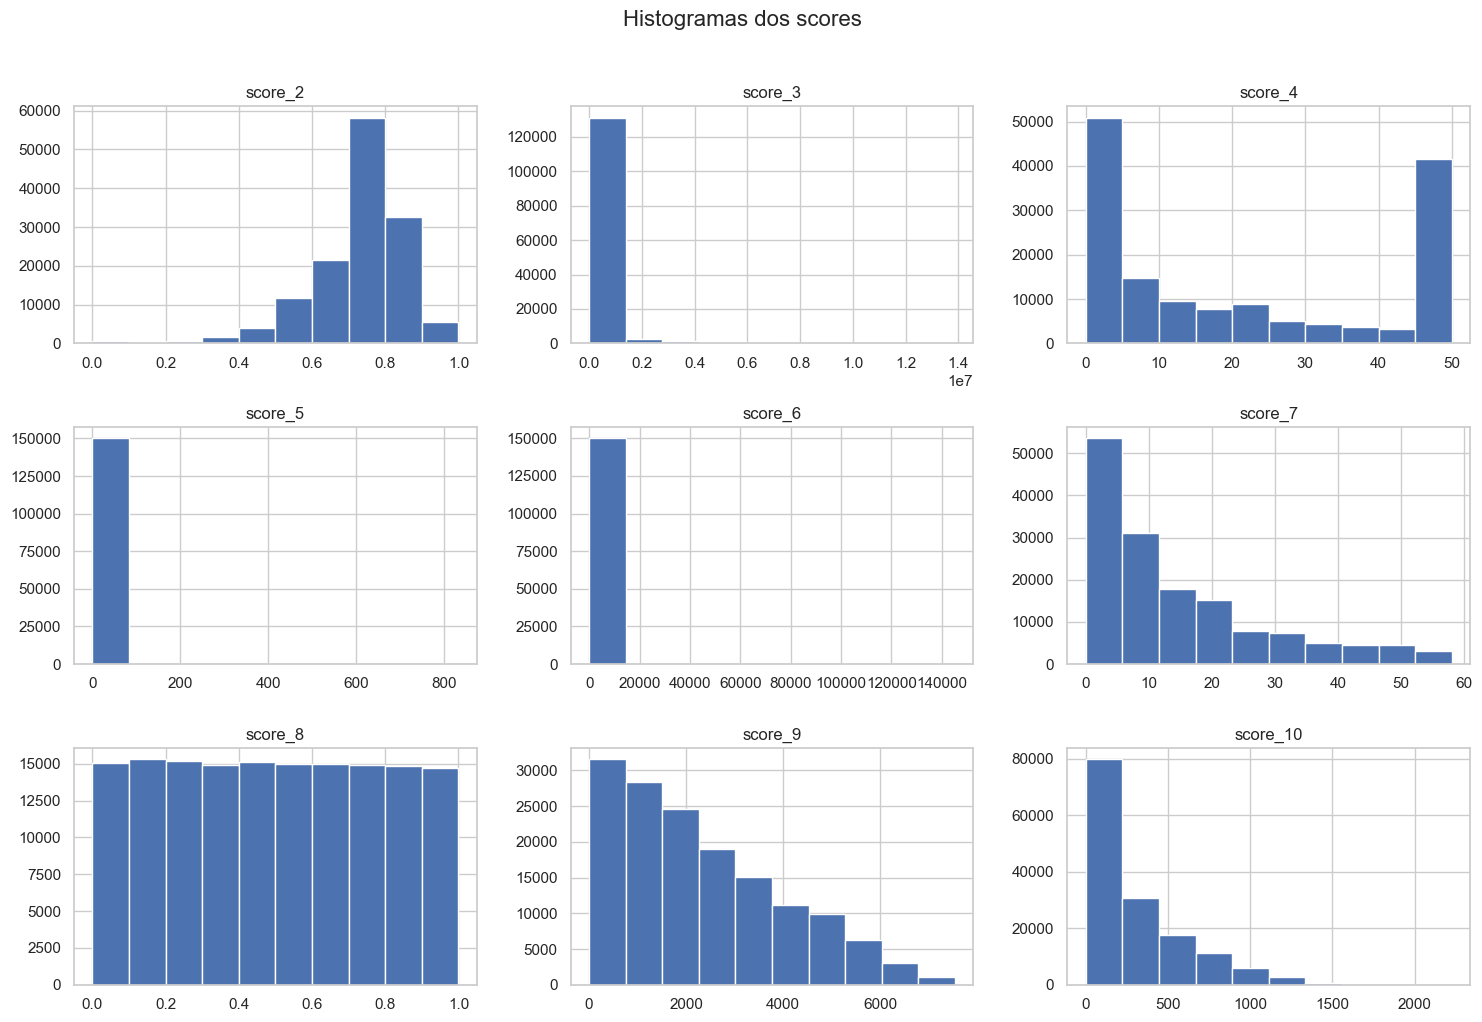

In [79]:
#Gera os histogramas
axarr = df[['score_2', 'score_3', 'score_4', 'score_5', 'score_6', 'score_7', 'score_8', 'score_9', 'score_10']].hist(figsize=(15, 10))

# Adiciona um título geral para a figura
plt.gcf().suptitle("Histogramas dos scores", fontsize=16, y=1.02)

plt.tight_layout()
plt.show()



* `score_2` exhibits left-skewness, meaning more people have a high score.`
* `score_7`, `score_9`, `score_10` show right-skewness, indicating that more people have a lower score.
* `score_8` is uniform.
* `score_4` has two peaks at the beginning and end.

The remaining scores are not well-discriminating and have a large spread.

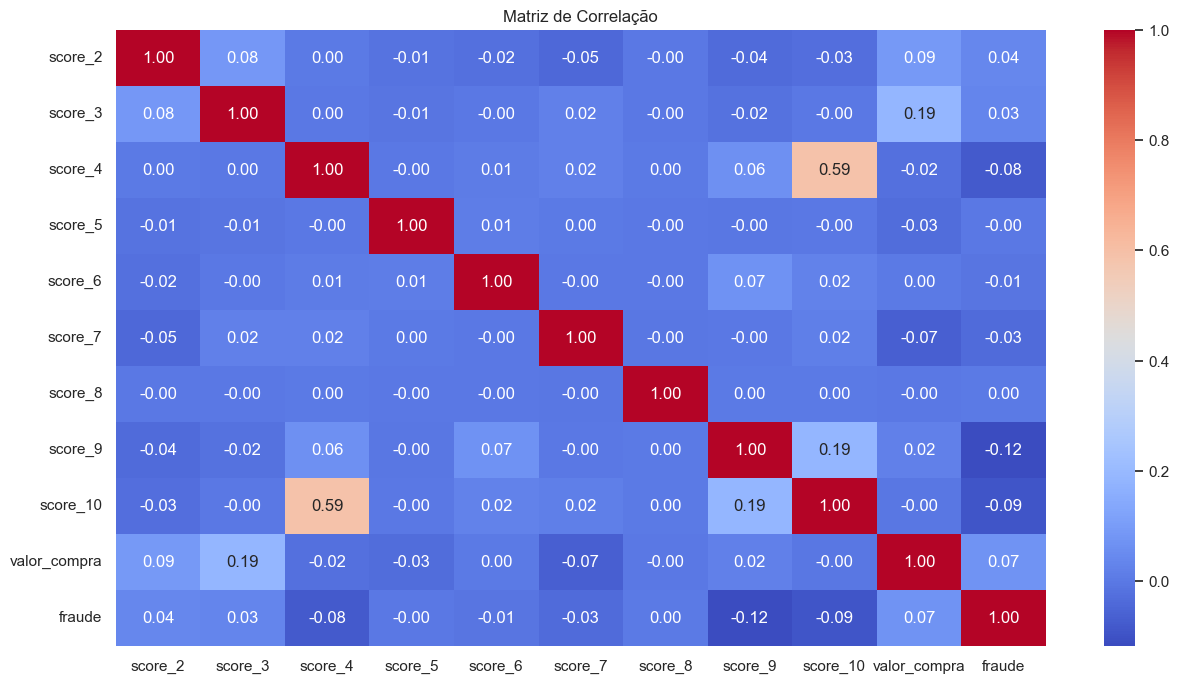

In [80]:

# Substitua 'df' pelos seus dados
corr = df[['score_2', 'score_3', 'score_4', 'score_5', 'score_6', 'score_7', 'score_8', 'score_9', 'score_10', 'valor_compra', 'fraude']].corr()
plt.figure(figsize = (15, 8))
sns.heatmap(corr, annot = True, cmap = "coolwarm", fmt = ".2f")
plt.title("Matriz de Correlação")
plt.show()


We have a positive correlation of 0.59 between `score_10` and `score_4`, which is moderate. I won't remove a feature, as it is not a strong correlation

Now let's see the `valor_compra` variable

In [81]:
df['valor_compra'].describe()

count    150000.000000
mean         43.523134
std          91.557888
min           0.020000
25%           9.380000
50%          20.610000
75%          40.692500
max        3696.350000
Name: valor_compra, dtype: float64

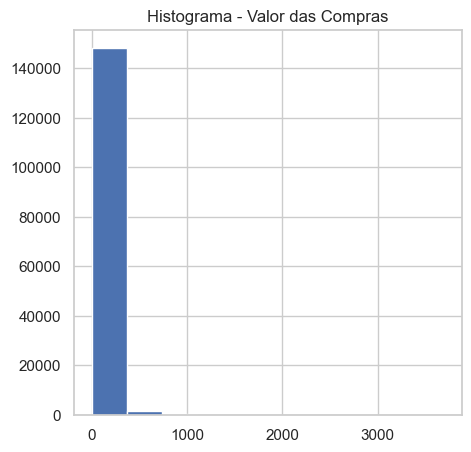

In [82]:
fig, ax = plt.subplots(figsize = (5, 5))
ax.set_title("Histograma - Valor das Compras")
df.valor_compra.hist(ax = ax);

We have a high range of purchase values and a high standard deviation. Most transactions were made with a lower purchase value. To facilitate visualization, I will set a limit of 450 on the x-axis

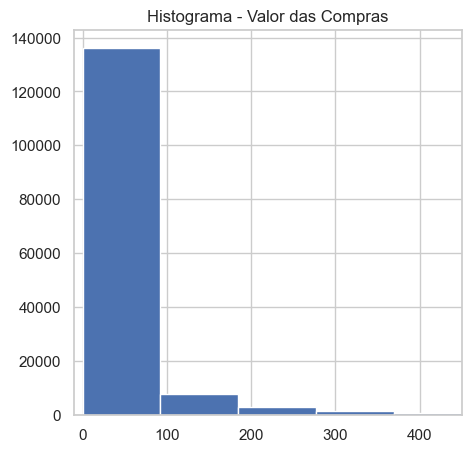

In [83]:
fig, ax = plt.subplots(figsize = (5, 5))
ax.set_title("Histograma - Valor das Compras")
ax.set_xlim(-10, 450)
df.valor_compra.hist(ax = ax, bins = 40);

# Multivariate Data Analysis

Hypotheses:
1. Is there any relationship between document delivery and fraud?
2. Is there any relationship between score and fraud?
3. Is there any relationship between country and fraud?
4. Is there any relationship between fraud and time?

In [84]:
df_subset = df[['score_3','entrega_doc_1','score_9','score_6','valor_compra', 'fraude']].copy()

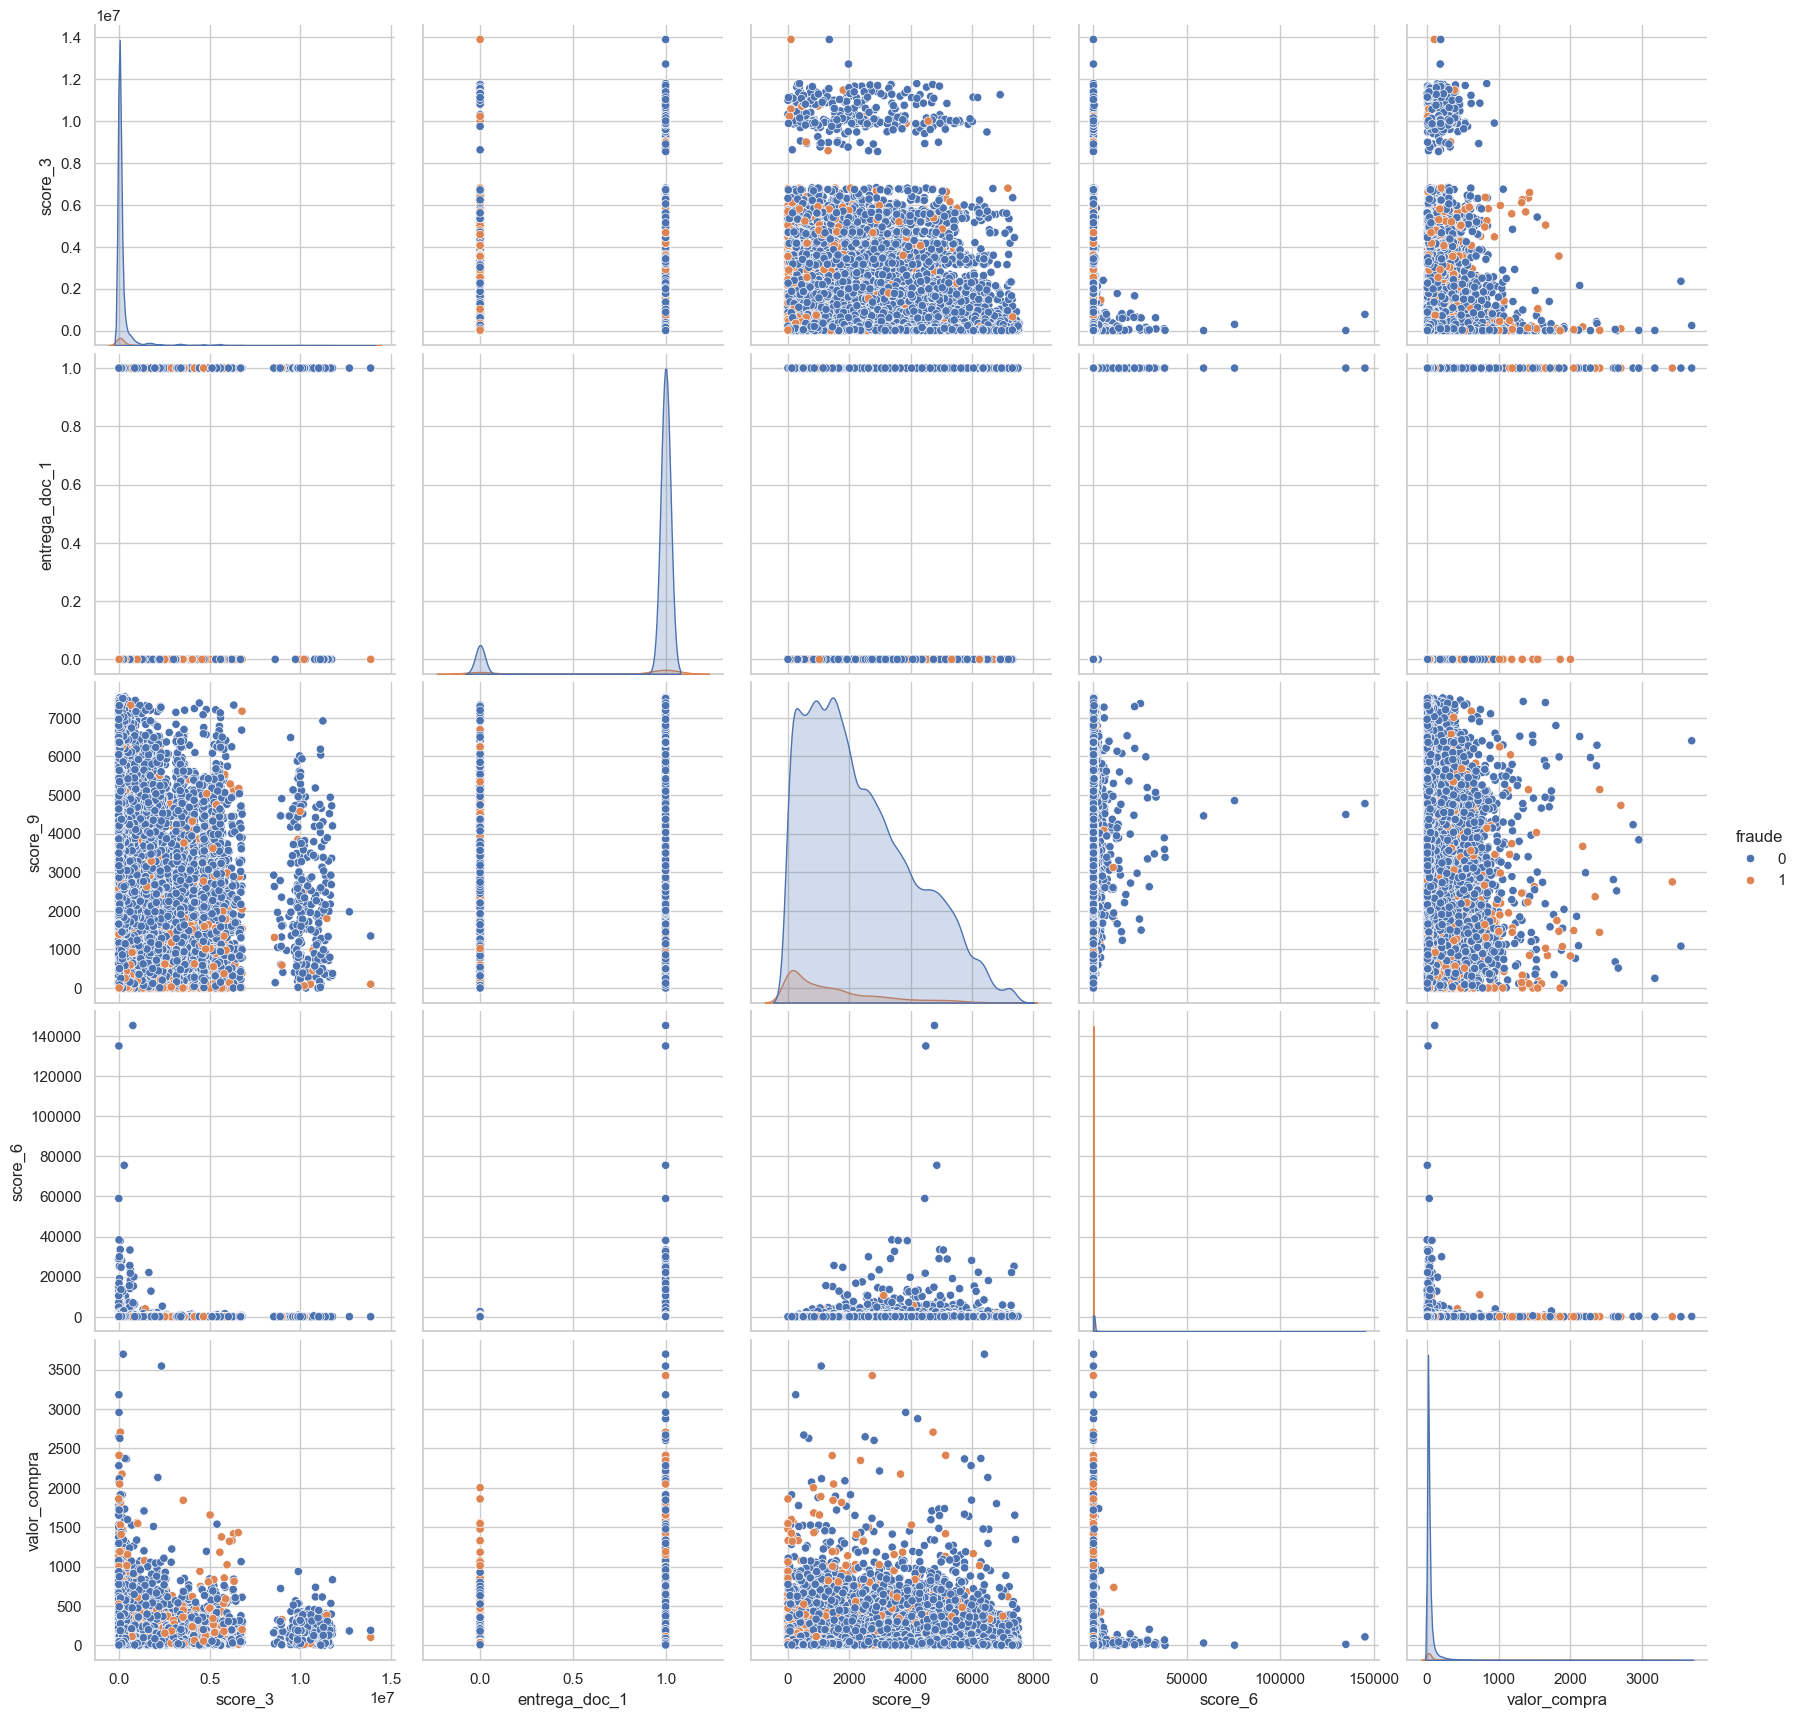

In [85]:
# matriz de gráficos scatter 
sns.pairplot(df_subset, hue='fraude', height=3.5)
    
# mostra o gráfico usando a função show() da matplotlib
plt.show()

It is not possible to identify a relevant relationship from the graphs. Below, I will conduct hypothesis tests for the target variable `fraud` and other variables.

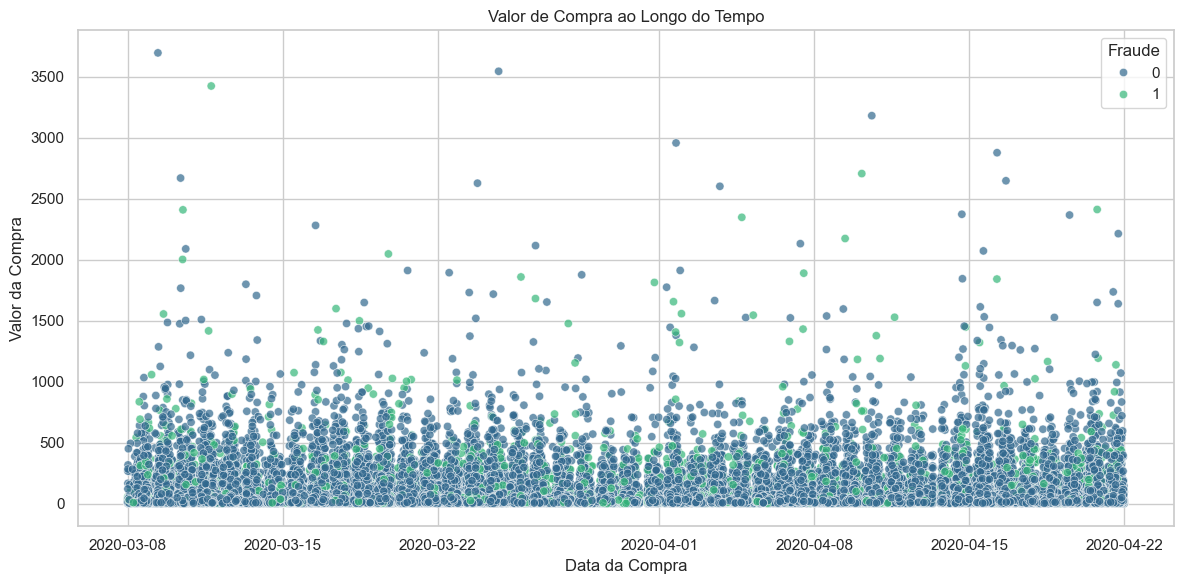

In [86]:
# Configuração do estilo do seaborn
sns.set(style="whitegrid")

# Criação do scatter plot utilizando o seaborn
plt.figure(figsize=(12, 6))
sns.scatterplot(x='data_compra', y='valor_compra', hue='fraude', data=df, palette='viridis', alpha=0.7)

# Configurando o título e os rótulos dos eixos
plt.title("Valor de Compra ao Longo do Tempo")
plt.xlabel("Data da Compra")
plt.ylabel("Valor da Compra")

# Adicionando legenda
plt.legend(title="Fraude", loc='upper right')

# Ajustes finais de layout
plt.tight_layout()

# Exibição do gráfico
plt.show()


It is not possible to notice a linear relationship of frauds over time

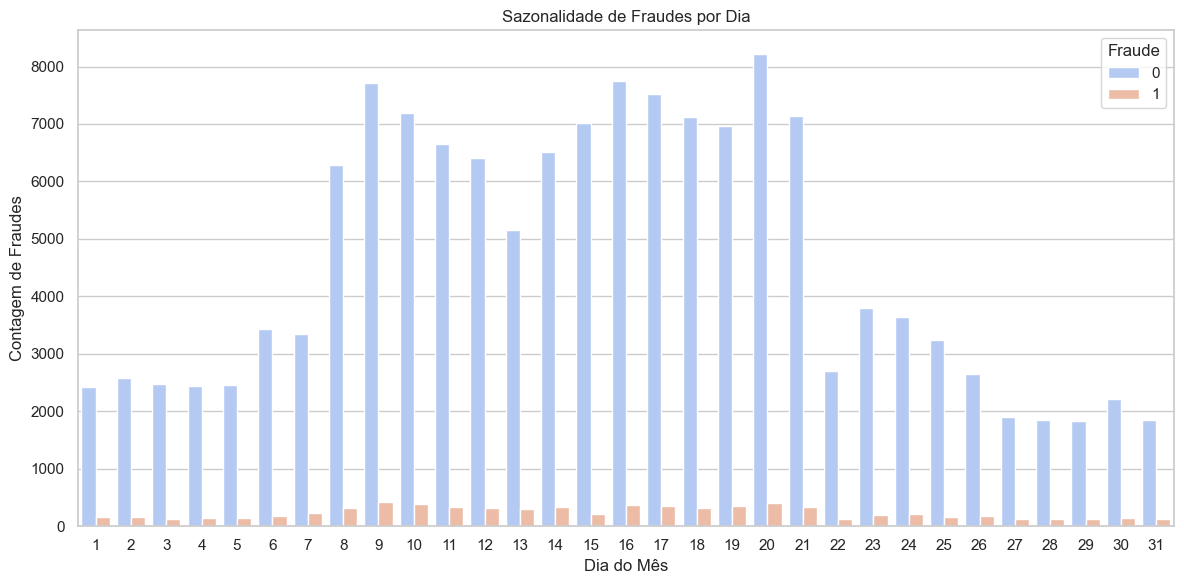

In [87]:
df_new = df.copy()

# Extrai o dia em uma coluna separada
df_new['dia'] = df_new['data_compra'].dt.day

# Configuração do estilo do seaborn
sns.set(style="whitegrid")

# Criação do count plot utilizando o seaborn
plt.figure(figsize=(12, 6))
sns.countplot(x='dia', hue='fraude', data=df_new, palette='coolwarm')

# Configurando o título e os rótulos dos eixos
plt.title("Sazonalidade de Fraudes por Dia")
plt.xlabel("Dia do Mês")
plt.ylabel("Contagem de Fraudes")

# Adicionando legenda
plt.legend(title="Fraude", loc='upper right')

# Ajustes finais de layout
plt.tight_layout()

# Exibição do gráfico
plt.show()


In [88]:
# Criar uma tabela de contingência
contingency_table = pd.crosstab(df_new["dia"], df_new["fraude"])

# Realizar o teste do qui-quadrado
chi2, p, _, expected = chi2_contingency(contingency_table)

print("Chi-squared value:", chi2)
print("P-value:", p)

if p < 0.05:
    print("We reject the null hypothesis. There is a significant relationship between 'day' and 'fraud'.")
else:
    print("We do not reject the null hypothesis. 'Day' and 'fraud' appear to be independent.")

Chi-squared value: 176.07910490044085
P-value: 1.3308511585064855e-22
We reject the null hypothesis. There is a significant relationship between 'day' and 'fraud'.


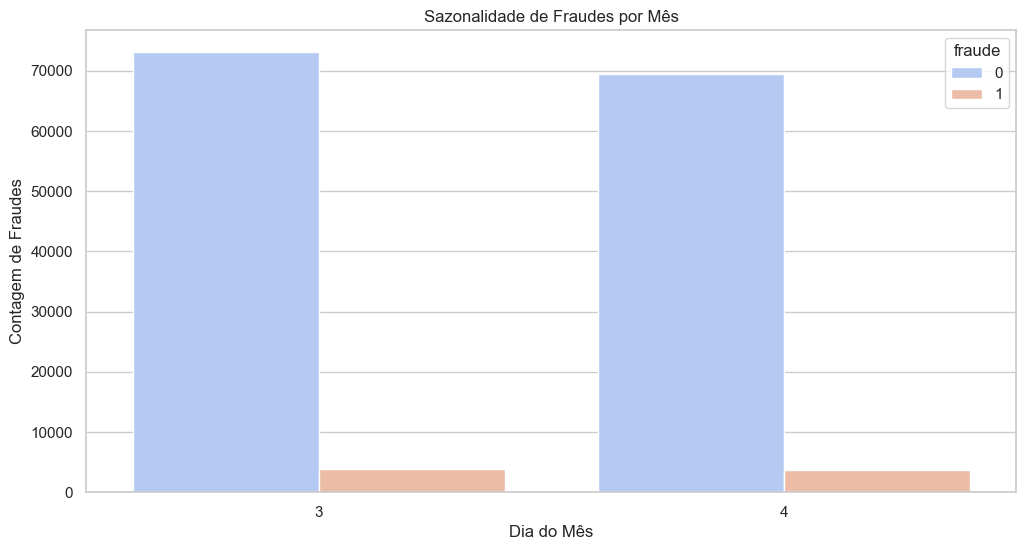

In [89]:
# Extrai o dia em uma coluna separada
df_new['mes'] = df_new['data_compra'].dt.month

# Define o tamanho da figura
plt.figure(figsize=(12, 6))

# Plotando a contagem de fraudes por dia
sns.countplot(x='mes', hue='fraude', data=df_new, palette='coolwarm')

# Configurando o título e os rótulos dos eixos
plt.title("Sazonalidade de Fraudes por Mês")
plt.xlabel("Dia do Mês")
plt.ylabel("Contagem de Fraudes")

# Mostra o gráfico
plt.show()

In [90]:
# Criar uma tabela de contingência
contingency_table = pd.crosstab(df_new["mes"], df_new["fraude"])

# Realizar o teste do qui-quadrado
chi2, p, _, expected = chi2_contingency(contingency_table)

print("Chi-squared value:", chi2)
print("P-value:", p)

if p < 0.05:
    print("We reject the null hypothesis. There is a significant relationship between 'Month' and 'fraud'.")
else:
    print("We do not reject the null hypothesis. 'Month' and 'fraud' appear to be independent.")    

Chi-squared value: 0.45471226672131904
P-value: 0.5001056271366706
We do not reject the null hypothesis. 'Month' and 'fraud' appear to be independent.


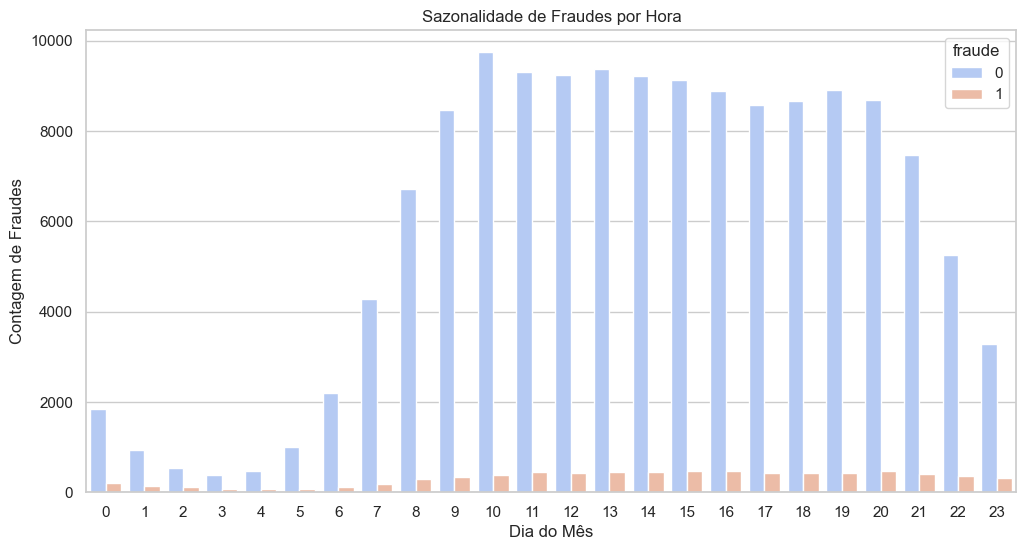

In [91]:
# Extrai o dia em uma coluna separada
df_new['hora'] = df_new['data_compra'].dt.hour

# Define o tamanho da figura
plt.figure(figsize=(12, 6))

# Plotando a contagem de fraudes por dia
sns.countplot(x='hora', hue='fraude', data=df_new, palette='coolwarm')

# Configurando o título e os rótulos dos eixos
plt.title("Sazonalidade de Fraudes por Hora")
plt.xlabel("Dia do Mês")
plt.ylabel("Contagem de Fraudes")

# Mostra o gráfico
plt.show()

In [92]:
# Criar uma tabela de contingência
contingency_table = pd.crosstab(df_new["hora"], df_new["fraude"])

# Realizar o teste do qui-quadrado
chi2, p, _, expected = chi2_contingency(contingency_table)


print("Chi-squared value:", chi2)
print("P-value:", p)

if p < 0.05:
    print("We reject the null hypothesis. There is a significant relationship between 'hour' and 'fraud'.")
else:
    print("We do not reject the null hypothesis. 'Hour' and 'fraud' appear to be independent.")


Chi-squared value: 841.6593861727897
P-value: 5.3030288311866235e-163
We reject the null hypothesis. There is a significant relationship between 'hour' and 'fraud'.


Although we reject the null hypothesis for day and hour, since we are not building a time series model, it doesn't make sense to include them as features. This column, however, could be used to assess the model's performance over time, as fraudsters may develop different techniques over time, and there could be a shift in population, which could degrade our model's performance over time. However, in the provided subset, we only have 2 months of data, and therefore, it won't be possible to observe such behaviors in such a short period. Thus, the column will be removed from the model.


Below, we will conduct hypothesis tests to check for a significant relationship between `score_1` and `fraud`, as well as the document delivery, country, and purchase amount.

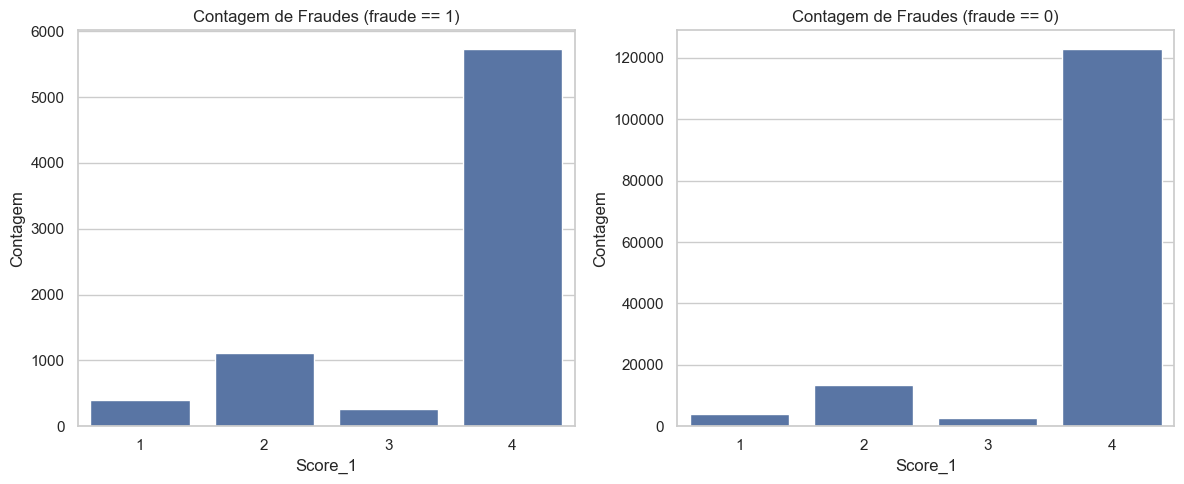

In [93]:
# Criar uma figura com dois eixos lado a lado
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Gráfico para fraude == 1
df_fraude_1 = df[df["fraude"] == 1]
sns.countplot(x="score_1", data=df_fraude_1, ax=axes[0])
axes[0].set_title("Contagem de Fraudes (fraude == 1)")
axes[0].set_xlabel("Score_1")
axes[0].set_ylabel("Contagem")

# Gráfico para fraude == 0
df_fraude_0 = df[df["fraude"] == 0]
sns.countplot(x="score_1", data=df_fraude_0, ax=axes[1])
axes[1].set_title("Contagem de Fraudes (fraude == 0)")
axes[1].set_xlabel("Score_1")
axes[1].set_ylabel("Contagem")

# Ajuste de espaço entre os gráficos
plt.tight_layout()
plt.show()

In [94]:
# Criar uma tabela de contingência
contingency_table = pd.crosstab(df["score_1"], df["fraude"])

# Realizar o teste do qui-quadrado
chi2, p, _, expected = chi2_contingency(contingency_table)

print("Chi-squared value:", chi2)
print("P-value:", p)

if p < 0.05:
    print("We reject the null hypothesis. There is a significant relationship between 'score_1' and 'fraud'.")
else:
    print("We do not reject the null hypothesis. 'Score_1' and 'fraud' appear to be independent.")


Chi-squared value: 584.4465798546843
P-value: 2.371872621590785e-126
We reject the null hypothesis. There is a significant relationship between 'score_1' and 'fraud'.


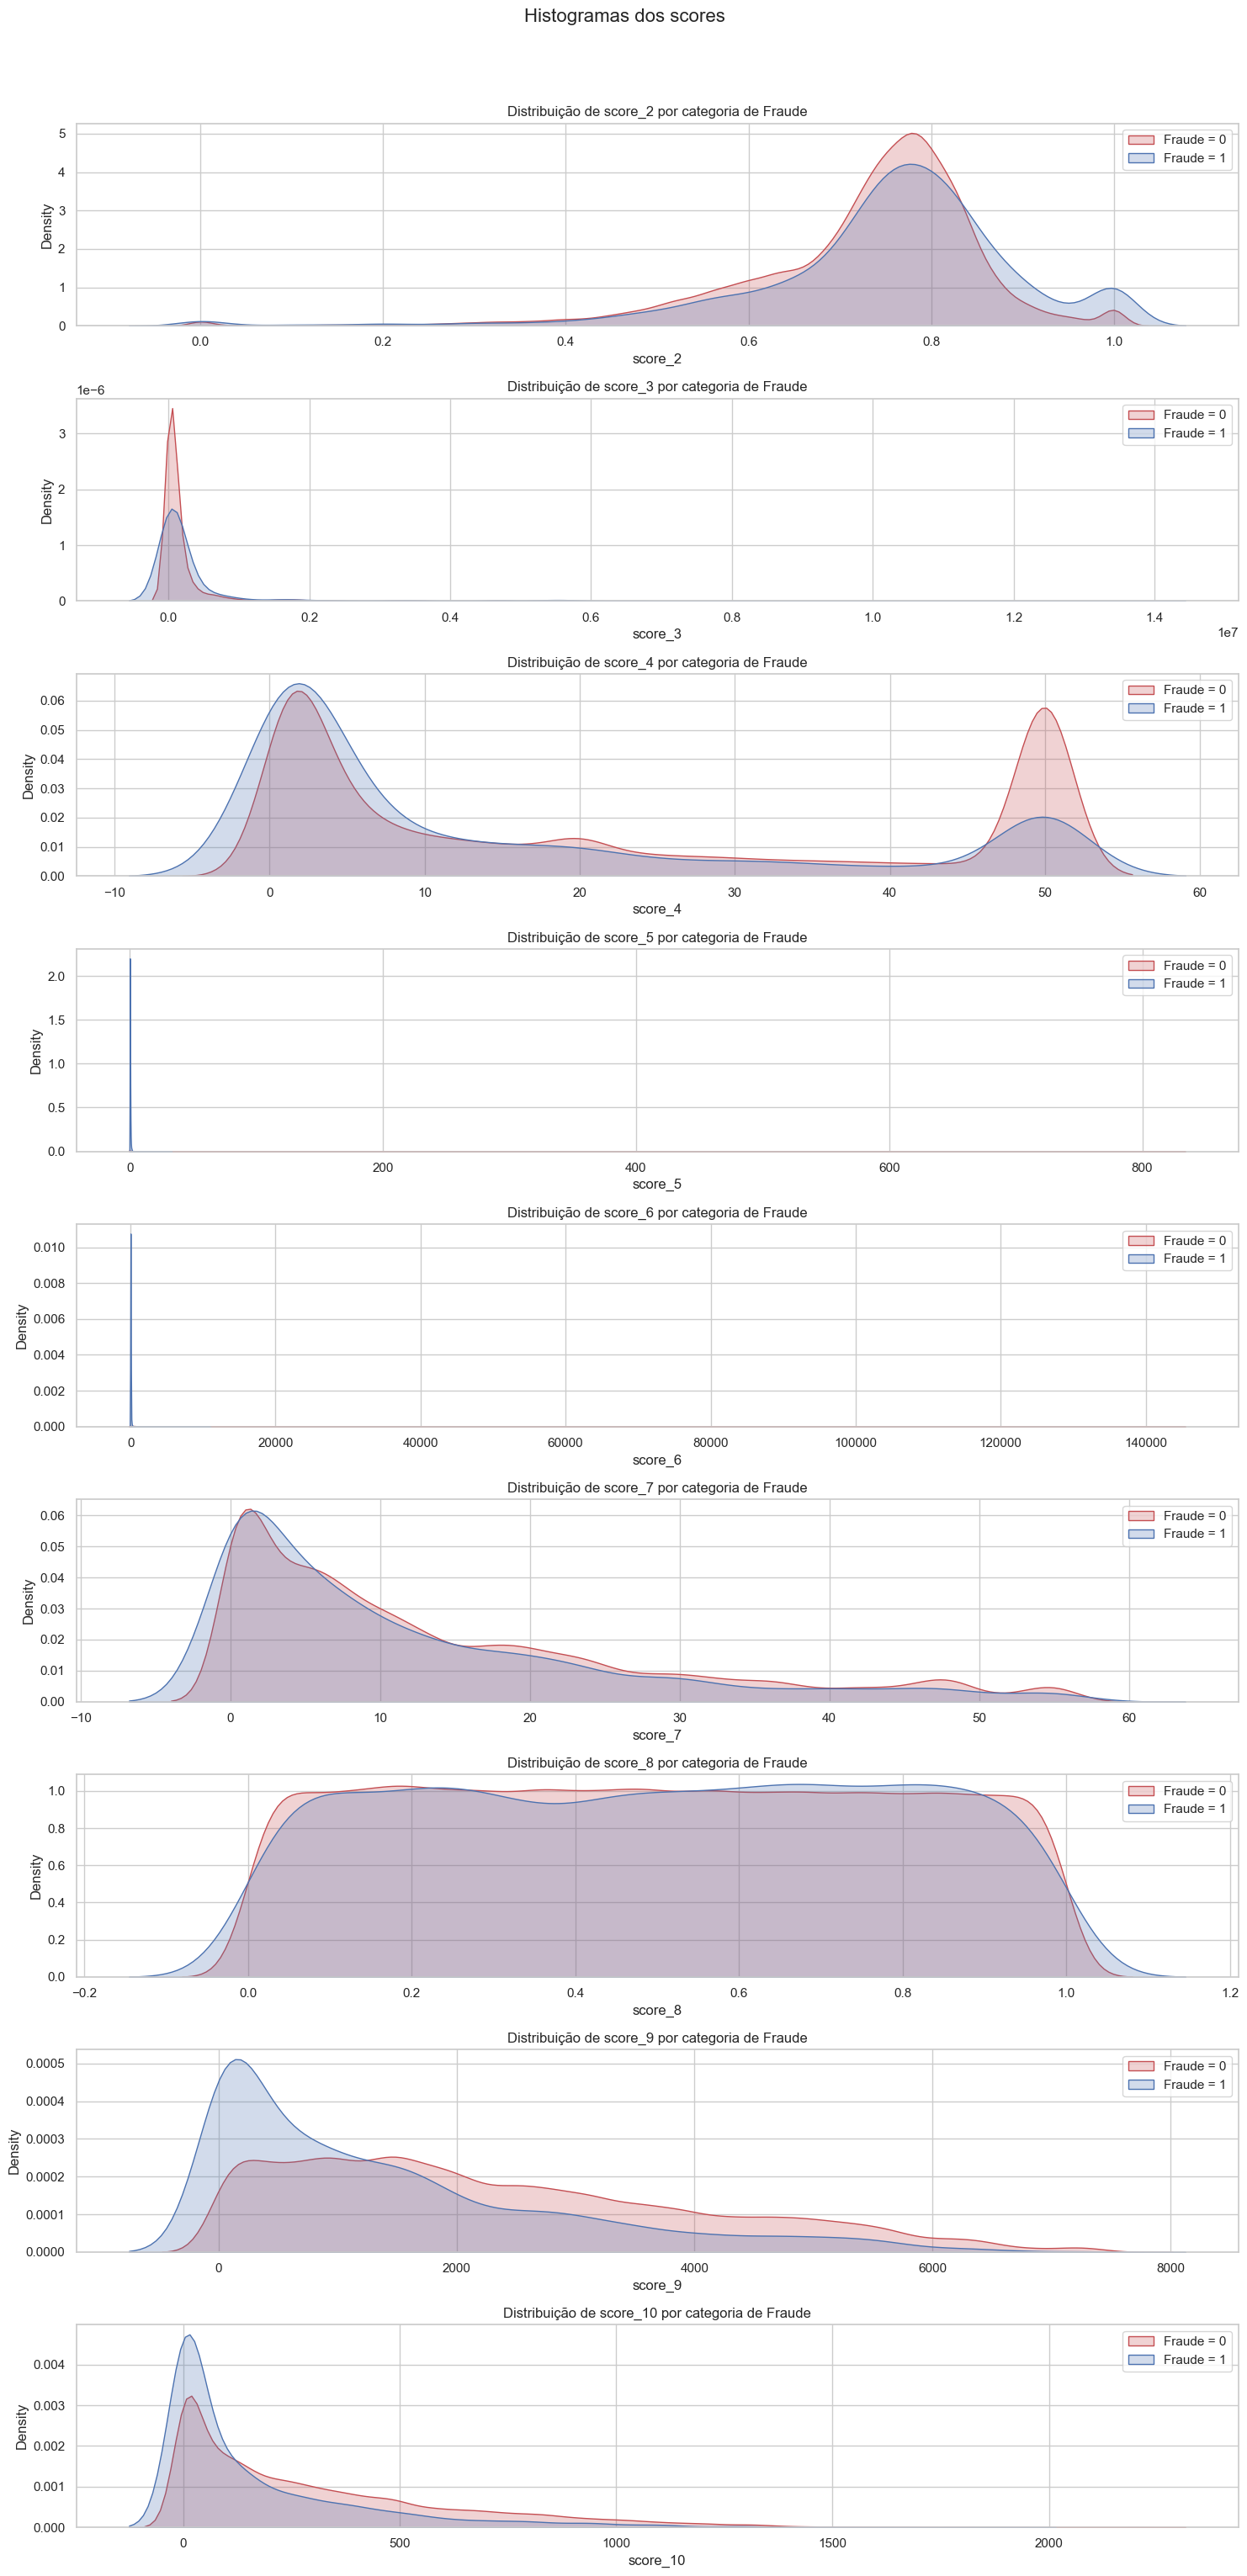

In [95]:
columns = ['score_2', 'score_3', 'score_4', 'score_5', 'score_6', 'score_7', 'score_8', 'score_9', 'score_10']

# Configurações de layout
fig, axarr = plt.subplots(len(columns), 1, figsize=(15, 30))

for i, col in enumerate(columns):
    sns.kdeplot(df[df['fraude'] == 0][col], ax=axarr[i], shade=True, label='Fraude = 0', fill = True, color = 'r')
    sns.kdeplot(df[df['fraude'] == 1][col], ax=axarr[i], shade=True, label='Fraude = 1', fill = True)
    axarr[i].set_title(f"Distribuição de {col} por categoria de Fraude")
    axarr[i].legend()

# Adiciona um título geral para a figura
plt.suptitle("Histogramas dos scores", fontsize=16, y=1.02)

plt.tight_layout()
plt.show()

In [96]:
for item in columns:
    # Count non-fraudulent and fraudulent transactions
    count_not_fraud = df.loc[(df['fraude'] == 0) & df[item].notnull(), 'fraude'].count()
    count_fraud = df.loc[(df['fraude'] == 1) & df[item].notnull(), 'fraude'].count()
    
    # Extract non-fraudulent and fraudulent data for the current item
    not_fraud_data = df.loc[df['fraude'] == 0, item]
    fraud_data = df.loc[df['fraude'] == 1, item]
    
    # Perform Kolmogorov-Smirnov test
    statistic, pvalue = stats.ks_2samp(not_fraud_data, fraud_data)
    
    alpha = 0.05
    
    # Print results
    print(f"\nColumn: {item}")
    print(f"Non-fraud count: {count_not_fraud}")
    print(f"Fraud count: {count_fraud}")
    print(f"P-value: {pvalue}")
    
    # Interpret the results
    if pvalue > alpha: 
        print("Conclusion: Does not reject null hypothesis - distributions are equal")
    else:
        print("Conclusion: Rejects null hypothesis - distributions are different")



Column: score_2
Non-fraud count: 130345
Fraud count: 6671
P-value: 1.2554815277967614e-78
Conclusion: Rejects null hypothesis - distributions are different

Column: score_3
Non-fraud count: 130345
Fraud count: 6671
P-value: 1.2341789595630104e-27
Conclusion: Rejects null hypothesis - distributions are different

Column: score_4
Non-fraud count: 142164
Fraud count: 7471
P-value: 3.711719104373309e-170
Conclusion: Rejects null hypothesis - distributions are different

Column: score_5
Non-fraud count: 142500
Fraud count: 7500
P-value: 1.3067725657730728e-44
Conclusion: Rejects null hypothesis - distributions are different

Column: score_6
Non-fraud count: 142489
Fraud count: 7500
P-value: 0.0
Conclusion: Rejects null hypothesis - distributions are different

Column: score_7
Non-fraud count: 142500
Fraud count: 7500
P-value: 5.651399372175339e-46
Conclusion: Rejects null hypothesis - distributions are different

Column: score_8
Non-fraud count: 142500
Fraud count: 7500
P-value: 0.24067987

The null hypothesis was not rejected only for `score_8`, where indeed, we did not observe differences in the distributions. Now, let's examine the delivery of documents

Finally, `valor da compra` and `fraude`

In [97]:
# Separate values based on the 'fraud' column
group1 = df[df['fraude'] == 0]['valor_compra']
group2 = df[df['fraude'] == 1]['valor_compra']

# Perform the test
stat, p = mannwhitneyu(group1, group2)

print('Statistic:', stat)
print('P-value:', p)

if p < 0.05:
    print("There is a statistically significant difference in the distributions between the groups.")
else:
    print("There is no statistically significant difference in the distributions between the groups.")

Statistic: 463387165.0
P-value: 5.049078387837292e-84
There is a statistically significant difference in the distributions between the groups.
